v6

作成した記事を批評するエージェントの導入

ルーターノードも加える

In [1]:
ver = "ver6"

ライブラリのインポート

In [3]:
# ライブラリのインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import create_react_agent
from typing import List, Dict
from langchain.schema import SystemMessage, HumanMessage
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

load_dotenv()


#LangchainのAPIを渡す
os.environ["LANGCHAIN_TRACING"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

#GPTのAPIを渡す
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

#TavilyのAPIを渡す
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")


出力の型を定義

In [4]:
class URLInfo(BaseModel):
    title: str = Field(description="サイトのタイトル")
    url: str = Field(description="サイトのURL")

class OutputSummrize(BaseModel):
    # URL_listをURLInfoモデルに変更
    URL_list: List[URLInfo] = Field(description="記事作成に利用されたサイトのタイトルとURL")


class OutputArticle(BaseModel):
    title: str = Field(description="記事のタイトル")
    main_text: str = Field(description="記事の中身")

class OutputReview(BaseModel):
    review_result: str = Field(description="批評の結果")
    edit_needed: bool = Field(description="修正の必要があるか")
    edit_suggest: str = Field(description="修正案")

class OutputEdit(BaseModel):
    edit_result: str = Field(description="修正の結果")

プロンプトの定義

In [5]:
search_system_template = '''
あなたはユーザーから与えられたトピックについて調査を行うアシスタントです。
調査で得られた情報と引用したサイトのタイトルとURLを出力してください。

##注意
    なるべく調査で得た情報はそのまま出力してください
    まとめや要約はしないでください
'''

summrize_system_template = '''
あなたは調査で得られたサイトの情報を集約するアシスタントです。
調査で取得したサイトのタイトルとURL１つ１つを辞書形式({{"title": "...", "url": "..."}})にし、リスト形式で出力してください。
'''

generate_system_template = '''
以下の内容を踏まえて、マークダウン形式で記事を作成してください。

指定されたコンテンツ {content} に関する記事を日本語で作成してください。
検索結果 {search_result} から得られる情報を整理し、読者にとって有益でわかりやすい記事を心がけてください。
記事のタイトル、導入、本文、まとめの構成を意識し、最新かつ正確な情報を盛り込んでください。
本文の末尾には、検索結果のサイトタイトルとURLを{URL_list}を参照の上、リスト形式で記載してください。

Steps
検索結果の内容を把握
search_resultを確認し、主要なトピックやキーワードを整理してください。
記事のアウトライン作成
タイトル
導入（リード文）
見出し（必要に応じて複数）
まとめ（結論やまとめ）
本文執筆
見出しや小見出しごとに論点をまとめ、論理的に構成してください。
検索結果から得られた情報や一般知識を補完し、正確かつオリジナリティを意識した内容にしてください。
結論・まとめ
記事全体を振り返り、要点を簡潔にまとめてください。
次の行動や関連トピックへの誘導など、読者が得られるメリットを提示してください。
最終チェック
誤字脱字、情報の正確性、読みやすさを確認し、必要に応じて修正してください。
引用元の表記
記事の末尾に、検索結果から参照したサイトのタイトルとURLをリスト形式で記載してください。
Output Format
マークダウン形式で出力してください。
改行や段落を保持し、見出しや箇条書きを適切に使ってください。
記事末尾に「引用元」として、サイトタイトルとURLを記載してください。
Examples
例:

タイトル: 「[検索結果の主要トピック]を徹底解説」
導入: この記事では…（簡単な背景情報と読者が得られるメリット）

本文

見出し1: 「[見出しのテーマ]」
[検索結果からの情報を例示しながら解説]
見出し2: 「[別の角度や詳細トピック]」
[具体的な事例や追加情報など]
まとめ: [全体の要点、読者への次のステップ]

引用元

サイト名
サイト名
(実際の記事では、上記より詳細かつ具体的に説明してください)

Notes
search_result や contentが十分でない場合は、想定しうる前提条件を補足して文章を構成してください。
あくまで検索結果を根拠にしつつも、独自の言い回しや整理を行い、オリジナリティを大切にしてください。
'''

review_system_template = '''
評価対象の記事（{main_text}）を以下の3観点でそれぞれ0〜10点で採点し、理由を説明したうえで修正の必要性をブール値（true / false）で示し、必要な場合は修正案を提示してください。

構成
誤字脱字・文法
表現・内容のわかりやすさ
出力フォーマット
構成: [点数]/10
誤字脱字・文法: [点数]/10
表現・内容のわかりやすさ: [点数]/10
評価理由:
各観点において、なぜその点数なのかを具体的に説明
修正の有無: [true or false]
true: 修正が必要な場合
false: 修正が不要な場合
修正案 (修正が必要な場合のみ)
例
入力記事: 「今日は天気がいいです。こうえんに行くと、こどもたちがとても楽しそうにあそんでいました。」

想定出力:

構成: 7/10
誤字脱字・文法: 8/10
表現・内容のわかりやすさ: 7/10
評価理由:
構成: 簡潔で理解はしやすいが、段落を分けて詳細を説明するとさらに良くなる
誤字脱字・文法: 「こうえん」は「公園」、「あそんでいました」は「遊んでいました」が望ましい
表現・内容のわかりやすさ: 全体的な内容は伝わるが、周囲の状況を少し描写すると魅力が増す
修正の有無: true
修正案:
「今日は天気がいいです。公園に行くと、子どもたちがとても楽しそうに遊んでいました。
周りの木々は新緑に包まれ、ピクニックをする家族もいて笑顔があふれていました。」
必要に応じて例を参照のうえ、指示に沿って出力してください。
'''

edit_system_template = '''
元の記事（{main_text}）を基に、修正案（{edit_suggest}）の指示に従って記事を修正し、最終版を出力してください。

修正案で指示された内容をすべて反映すること
元の記事の文体や構成は、修正案が特に指示していない限り保持すること
誤字脱字や表現の不整合があればあわせて修正すること
手順
修正案を確認する
変更箇所や追記・削除の指示などを正確に把握してください。
元の記事を確認する
修正案で指定されている箇所を重点的に確認し、対応する内容を特定してください。
指示に基づき修正を行う
追記や文章の書き換えなど、必要な修正を行ってください。
全体の流れや文脈が崩れないように注意しながら改稿してください。
整合性をチェックする
前後の文脈や用語の統一を含め、記事の整合性を確認してください。
再度誤字脱字や表現のブレがないか検証してください。
最終的な記事として出力する
必要な変更がすべて適用されているかを確認し、最終的に完成した記事を提示してください。
出力形式
修正済みの記事本文のみを提示してください。
余計な解説やメタ情報は含めないでください。
例
例：入力（修正案 & 元の記事）

修正案:
第一段落の最後の文を削除する。
第二段落に記載の数値データを最新のものに置き換える。
元の記事（一部抜粋）:
[元の文章がここに入ります]
例：出力（修正後の記事）
[修正を反映させた文章のみを提示。指定された文章の削除や数値修正を適切に行い、余計なコメントは付けずに出力。]

(実際の元の記事や修正案が長い場合は、それに応じて適切に修正を行ってください)

備考
修正指示に曖昧な点がある場合は、文脈から最も適切と思われる内容で補ってください。
記事全体のトーンや文体が著しく変わらないよう配慮してください。
出力時は完成した記事のみを提示し、他の要素は含めないでください。
'''


エージェントの定義

In [6]:
#ツールを利用するエージェント
#ChatOpenAIでチャットモデルを渡す（モデルは変更できる）
model = ChatOpenAI(model="gpt-4o-mini")

# Tavilyの定義　max_results:何件文の検索結果を保持するか
search = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True
)
tools = [search]

search_agent = create_react_agent(model, tools)

In [7]:
#URLを保持するエージェント
summrize_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", summrize_system_template)
    ]
)

summrize_output = model.with_structured_output(
    OutputSummrize
)

summrize_agent = summrize_prompt | summrize_output

In [8]:
#記事作成を行うエージェント
generate_prompt = ChatPromptTemplate.from_messages(
    [
        ("user", generate_system_template),
    ]
)

generate_output = model.with_structured_output(
    OutputArticle
)
generate_agent = generate_prompt | generate_output


In [9]:
#批評を行うエージェント
review_prompt = ChatPromptTemplate.from_messages(
    [
        ("user", review_system_template),
    ]
)

review_output = model.with_structured_output(
    OutputReview
)
review_agent = review_prompt | review_output

In [10]:
#修正を行うエージェント
edit_prompt = ChatPromptTemplate.from_messages(
    [
        ("user", edit_system_template),
    ]
)

edit_output = model.with_structured_output(
    OutputEdit
)
edit_agent = edit_prompt | edit_output

stateの定義

In [11]:
class State(TypedDict):
    #入力
    content: str #ユーザーが入力した記事の内容
    
    #調査関連
    search_result: str #LLMが調査を行った結果を格納
    URL_list:List[Dict[str, str]] #URLのリスト
    
    #記事作成関連
    title: str #生成された記事のタイトル
    main_text:str #生成された記事の内容
    
    #批評関連
    review_result: str #批評の結果　本文
    edit_needed: bool #修正の有無
    edit_suggest: str #修正案

    #修正関連
    edit_result: str #修正後の本文

各ノードの関数

In [12]:
def search(state: State):
    response = search_agent.invoke(
        {"messages": [
            {"role": "system", "content": search_system_template},
            {"role": "user", "content": state["content"]}
            ]
        }
    )
    state["search_result"] = response["messages"][-1].content
    return state

def search_summrize(state: State):
    response = summrize_agent.invoke(state)
    state["URL_list"] = response.URL_list
    return state

def generate_article(state: State):
    response = generate_agent.invoke(state)
    state["title"] = response.title
    state["main_text"] = response.main_text
    return state

def review_article(state: State):
    response = review_agent.invoke(state)
    state["review_result"] = response.review_result
    state["edit_needed"] = response.edit_needed
    state["edit_suggest"] = response.edit_suggest
    return state

def edit_article(state: State):
    response = edit_agent.invoke(state)
    state["edit_result"] = response.edit_result
    return state

def router(state):
    # This is the router
    messages = state["edit_needed"]
    if messages :
        return "edit_article"
    else:
        return "end"


グラフの作成

In [13]:
#グラフの定義
workflow = StateGraph(State)

#ノードの定義
workflow.add_node("search", search)
workflow.add_node("search_summrize", search_summrize)
workflow.add_node("generate_article", generate_article)
workflow.add_node("review_article", review_article)
workflow.add_node("edit_article", edit_article)

#エッジの定義
workflow.add_edge(START, "search")
workflow.add_edge("search", "search_summrize")
workflow.add_edge("search_summrize", "generate_article")
workflow.add_edge("generate_article", "review_article")
workflow.add_edge("edit_article", END)

workflow.add_conditional_edges(
    "review_article", # <- 起点のエージェント
    router, # <- ルーターの戻り値を条件とするという定義
    {"edit_article": "edit_article", "end": END}, # <- 2パターンの定義
)


#コンパイル
app = workflow.compile()


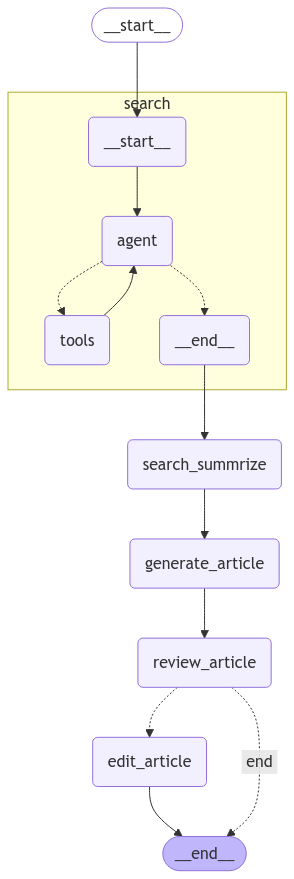

In [14]:
#グラフの可視化
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))
from IPython.display import Image, display


トピックの定義

In [15]:
initial_state = State()
initial_state["content"] = "中居正広"


グラフの実行

In [16]:
output = app.invoke(initial_state)
output

{'content': '中居正広',
 'search_result': '1. 中居正広 (中居 正広, Nakai Masahiro, born August 18, 1972) is a Japanese television host, actor, news presenter, and radio personality. He has hosted many TV specials, including 27 Hour Television and Kouhaku Uta Gassen. \n   - 出典: [Wikipedia - Masahiro Nakai](https://en.wikipedia.org/wiki/Masahiro_Nakai)\n\n2. 中居正広、9000万円女性トラブルで「違約金10億円」の大誤算…番組もCMも続々中止で弱音「俺はもう芸能人をやめる」など、最近のトラブルの影響で、彼の出演する番組は急遽中止になります。\n   - 出典: [Yahoo!ニュース - 中居正広、9000万円女性トラブル](https://news.yahoo.co.jp/articles/3a376f85eff0b974574bcd649e61eacd80cdbac5)\n\n3. 中居正広は2023年6月頃に女性との会食中に重大なトラブルが発生し、9000万円の示談金を支払う結果となったことが報じられています。\n   - 出典: [NEWSポストセブン - 中居正広が女性との間に重大トラブル](https://www.news-postseven.com/archives/20241220_2012279.html?DETAIL)\n\n4. 中居正広のトラブルは、示談金が9000万円に上るため、問題が実刑判決に繋がる可能性があるとの見方もあります。このトラブルの影響で、彼が関わるCMや番組が次々と中止されている。\n   - 出典: [デイリー新潮 - 中居正広「実刑判決が下るレベルの示談金」](https://news.yahoo.co.jp/articles/606b2761da2de699e751ab176dbc6b7567bede28)\n\n5. 中居正広は、重病から復帰後の会食でのトラブルが報じられており、その影響でス

ドキュメント化

In [18]:
markdown_text = f"""
{output['title']}

{output['edit_result']}

"""
file_name = f"{ver}_{output['title']}.md"
folder = "記事格納"
file_path = os.path.join(folder, file_name)

# Markdownファイルとして保存する（.mdの拡張子推奨）
with open(file_path, "w", encoding="utf-8") as file:
    file.write(markdown_text)

print(f"{file_name} に保存しました。")


ver6_中居正広の最近のトラブルと芸能界への影響.md に保存しました。


ストリーミングでの取得方法

In [16]:
'''
for event in app.stream(initial_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)
'''  

'\nfor event in app.stream(initial_state):\n    for k, v in event.items():\n        if k != "__end__":\n            print(v)\n'